# Introduction to Machine Learning via Nearest Neighbours


## Part 1 - Implement k-Nearest Neighbours (kNN) - 30 points

### Note:
This exercise closely follows the post by Scott Fortmann-Roe about bias-variance tradeoff (see references below). It is recommended that you think about each of the questions before referring to that essay.

In this exercise you will get familiar with a **non-parapmetric** learning algorithm called k-Nearest Neighbours (kNN), and will implement it. You will then analyse the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.

For this exercise we will use hypothetical and artificial generated data.
### Nearest Neighbours
The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

Implement a class called KNNClassifier and two methods:
- `fit`: should recieve the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]). 
- `predict`: should recieve a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

Use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

Use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, you may predict whichever label you wish.

You may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference.

* Bonus for nurdes: use kd-tree for efficiency, see [nearest neighbour search in wiki](https://en.wikipedia.org/wiki/Nearest_neighbor_search)

* Bonus for lazy nurdes: use [scipy's kd implementation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html)

In [317]:
class kNNClassifier:
  def __init__(self, n_neighbors):
    self.n_neighbors = n_neighbors
  def fit(self, X, y):
    self.train = X
    self.labels = y
    
  def predict(self, X):
      from scipy import stats
      ## if K is equal to the number of train data set vectors, return the same label for all
      if self.n_neighbors == self.train.shape[0]:
          ### find the most common label in the train data set, and return that label for each vector in the test data set
          return np.array([np.where(np.mean(self.labels) > 0,1,-1)] * X.shape[0])
    ### Calculate distance between each input vector and the train_vector (row = input_vecotor,column=train_vecotr)
      distance_matrix = np.sqrt(np.sum((X[:, None, :] - self.train[None, :, :])**2, axis=-1))
    ### keep index of k smallest elements from each row in the distance_matrix , i.e find index of closest k elements
      closest_k_indices = np.argpartition(distance_matrix, self.n_neighbors,axis=1)[:,:self.n_neighbors] 
    
    ### Replace each element (index of closest vector) and replace it with it's label
      closest_k_values = np.take(self.labels,closest_k_indices)
      
    ### Find mode of each row and append the output array with its label.
      output = []
      for row in closest_k_values:
        row_unique,count = np.unique(row,return_counts=True)
        output.append(row_unique[count.argmax()])
      return np.array(output)
        
      
 

## Part 2 - Learn and evaluate kNN algorithm on artificial data

kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe you could say that the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value for it, is choosing the balance between bias and variance as discussed in class.




### An applied example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

Use the given function `generate_data(m)` to create m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [318]:
import numpy as np
import matplotlib.pyplot as plt

def true_boundary_voting_pred(wealth, religiousness):
  return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, seed=None):
  # if seed is not None, this function will always generate the same data
  np.random.seed(seed) 
  
  X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
  y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
  y[y==0] = 1
  samples_to_flip = np.random.randint(0,m//10)
  flip_ind = np.random.choice(m, samples_to_flip, replace=False)
  y[flip_ind] = -y[flip_ind]
  return X, y

def plot_labeled_data(X, y, no_titles=False):
  republicans = (y==1)
  democrats = (y==-1)
  plt.scatter(X[republicans,0], X[republicans,1], c='r')
  plt.scatter(X[democrats,0], X[democrats,1], c='b')
  if not no_titles:
    plt.xlabel('Wealth')
    plt.ylabel('Religiousness')
    plt.title('Red circles represent Republicans, Blues Democrats')
    
  plt.xlim([0, 10]);
  plt.ylim([0, 10]);
  plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');

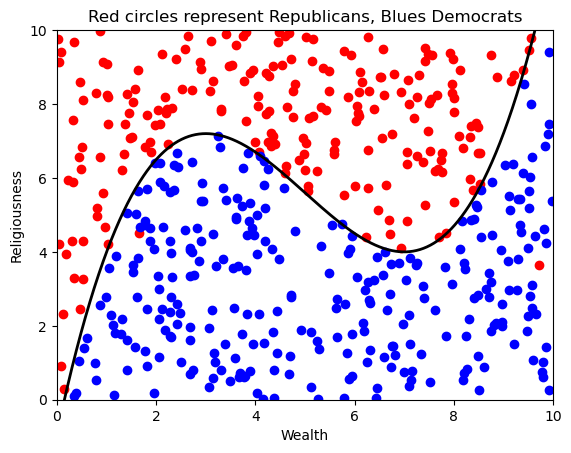

In [319]:
# Play this several times to see different sampling sets
X, y = generate_data(m=500)
# plot_labeled_data(X, y)

model = kNNClassifier(1)
model.fit(X,y)
y_pred = model.predict(X)

plot_labeled_data(X,y_pred)


### 1. Analyse the properties of kNN - 30 points
Generate multiple sample data sets of size 500 (use the given function above), and plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99).

The decision plane should cover the range [0,10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors. It should look something like this:

![decision plane](https://doc-14-14-docs.googleusercontent.com/docs/securesc/flg80o8vb463a3nd3i6da8hemig5me1b/hvii8ll4dscju8o17vuo2aab9aei8hgr/1543334400000/11934753179242311747/03422859225809857490/1chmyojft_R6ftfBhoPZuGN9AykyUS-cw?e=view&nonce=4i4j8lssjk6kc&user=03422859225809857490&hash=k9ogjg94ssot1vocu8uoeg4okkeekg6f)

https://drive.google.com/file/d/1chmyojft_R6ftfBhoPZuGN9AykyUS-cw/view?usp=sharing

Answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?
- Can you describe when do you underfit or overfit the data? 
- How does the complexity of this model depends on k?

* Bonus for nurdes:
Use interactive slider for k to see the effect [see [interact](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)]

C:\Users\yosefos\AppData\Local\Temp\ipykernel_1480\4112181928.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  max_freq_label,counts = stats.mode(closest_k_values,axis=1)


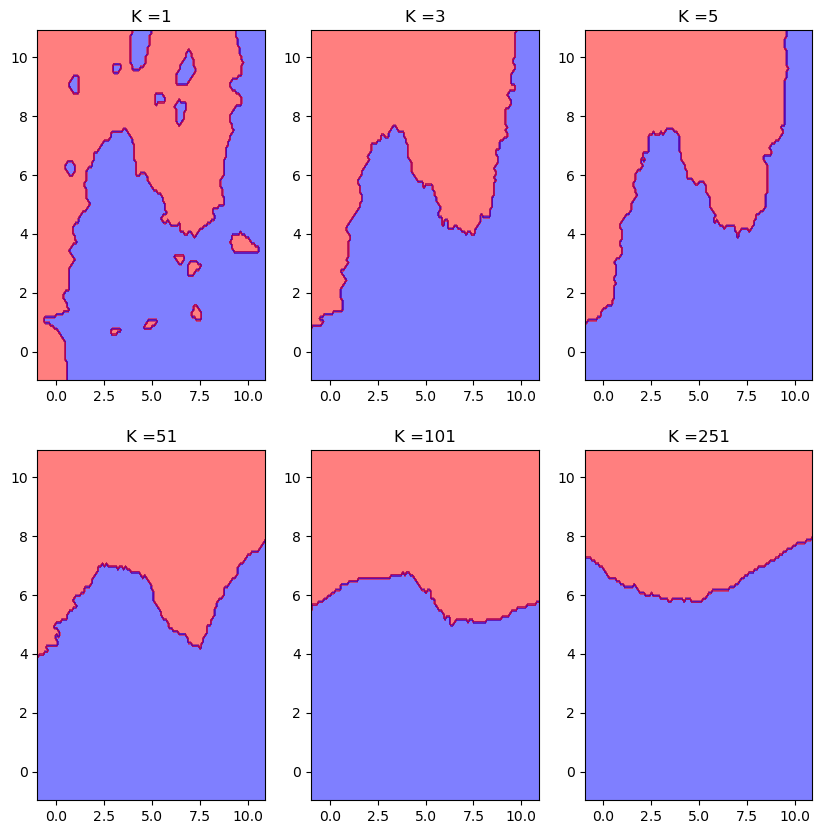

In [320]:
### This function creates a grid of all possible religiousness and wealth values and colors each point in the grid with the label it recieves by the classifier
def plot_decision_boundary(model, X, y):
    # Get the minimum and maximum values for each feature in the dataset
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create a grid of points with the minimum and maximum values
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Use the trained model to predict the category of each point in the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Plot the decision boundary using the grid of points and their predicted categories
    Z = Z.reshape(xx.shape)
    plt.contourf( xx,yy, Z, alpha=0.5,colors=['blue','red'])



### values of K that will be ploted
K_vals = [1,3,5,51,101,251]
plt.figure(figsize=(10,10))

### iterate through all possible K values, and plot create the plot
for i,k in enumerate(K_vals):
    X, y = generate_data(m=500,seed=2)
    plt.subplot(2,3,i+1)
    model = kNNClassifier(k)
    model.fit(X,y)
    y_pred = my_model.predict(X)
    plot_decision_boundary(model, X, y_pred)
    plt.title('K =' + str(k))



1. As K increases, the decision plane becomes more of a stright line
2. Underfitting happens when K is large, as the label is affected by unsimilar points.
   Overfitting happens when K is small, as the label is designated only by samples which are very similar.
3. Complexity decreases as K increases, since the model abillity to distict decreases

### 2. Finding the optimal k - 15 points
Sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. Plot the train vs validation error for several k values, and choose the best k. Where do you underfit/overfit the data? Finally, estimate the generalization error of your chosen classifier using the test set. What would happen if you optimize directly on test? is the optimal k the same?


Best K is 3
Underfitting happens when K is large, while overfitting when K is small, as seen by the error rate.
Error rate of test set is: 0.105
Had i optimized directly on test, K would have changed to the one that minimized the error for the test set: 5


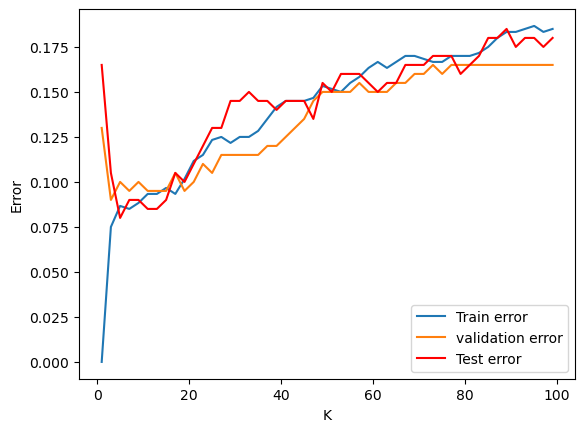

In [321]:
# Generate data
X, y = generate_data(m=1000)
# Split data to train,validation and test
train,validation,test  = X[:600,:] , X[600:800,:],X[800:,:]

# Generate K values
K_vals = np.arange(1,101,2)

# Initialize lists that hold the error for each K in the train and validation set
train_error = []
validation_error = []

# Iterate through all K values, calculating the error of test and validation sets
for k in K_vals:
    # Train fit and predict current K
    model = kNNClassifier(k)
    model.fit(train,y[:600])
    train_prediction = model.predict(train)
    validation_prediction = model.predict(validation)
    # Calculate and append (to the error lists) the error of current k 
    train_error.append(sum(y[:600] != train_prediction) / 600)
    validation_error.append(sum(y[600:800] != validation_prediction) / 200)


# Plot train and validation error rate as functions of K
plt.plot(K_vals,train_error,label ="Train error");
plt.plot(K_vals,validation_error,label ="validation error");


# Print the K yielding lowest error rate
print("Best K is",K_vals[np.argmin(validation_error)])
print("Underfitting happens when K is large, while overfitting when K is small, as seen by the error rate.")

# Calculate error rate of test set
model = kNNClassifier(K_vals[np.argmin(validation_error)])
model.fit(train,y[:600])
test_error = sum(model.predict(test) != y[800:]) / 200
print("Error rate of test set is:",test_error)

# Optimize directly on test
test_error = []
for k in K_vals:
    # Train fit and predict current K
    model = kNNClassifier(k)
    model.fit(train,y[:600])
    test_prediction = model.predict(test)
    # Calculate and append error of current k 
    test_error.append(sum(y[800:] != test_prediction) / 200)
# plot test error rate
plt.plot(K_vals,test_error,label ="Test error",color = 'red');
plt.legend();
plt.xlabel("K");
plt.ylabel("Error");
print("Had i optimized directly on test, K would have changed to the one that minimized the error for the test set:",K_vals[np.argmin(test_error)])

### 3. Using cross validation - 25 points
This time, put the test data aside (0.2 of the data), and apply 5-fold CV on the remaining data to evaluate the performance of each k value. 
What is the size of the validation and train set now, in each CV iteration?
Did your final model selection change? Explain why.

In [323]:
# Initialize the list holding the mean error for each k and the splitting indices.
mean_error_per_k = []
CV_range  = np.linspace(0,800,6,dtype=int) 

for k in K_vals:
    # Initialize list holding error of each fold for current k
    curr_k_error = []
    for i in range( len(CV_range) - 1 ):
         # generate test and vlidation sets of curent fold
         valid = X[CV_range[i]:CV_range[i+1],:]
         valid_labels = y[CV_range[i]:CV_range[i+1]]
         test = np.concatenate((X[0:CV_range[i],:],X[CV_range[i+1]:800,:]),axis=0)
         test_labels = np.concatenate((y[0:CV_range[i]],y[CV_range[i+1]:800]),axis=0)

        # Fit and predict current fold and k  
         model= kNNClassifier(k)
         model.fit(test,y)
         valid_pred = model.predict(valid)
        # Calculate error of current fold andt k
         curr_k_error.append(sum(valid_labels != valid_pred)/160)
    
    # Apend mean_error_per_k with the mean of curr_k_error
    mean_error_per_k.append(np.mean(curr_k_error))

# Choose K with minimal error
best_k = K_vals[np.argmin(mean_error_per_k)]
print("Best K using 5-fold CV is:",best_k)

# Fit, best k to model
model = kNNClassifier(best_k)
model.fit(X[0:800],y[0:800])
print("Test error using 5-fold CV best k is:",sum(model.predict(X[800:]) != y[800:])/200)
print("Model selection changed because using the 5-fold CV method, we chose k fitting a larger set of data, meaning it fits more scinerios, and is therefore less biased compared to the previous one")



Best K using 5-fold CV is: 15
Test error using 5-fold CV best k is: 0.08
Model selection changed because using the 5-fold CV method, we chose k fitting a larger set of data, meaning it fits more scinerios, and is therefore less biased compared to the previous one


## References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html